In [1]:
import numpy as np
import pandas as pd
from transformers import BertModel
from keybert import KeyBERT
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

C:\Users\mink5\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\mink5\anaconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
data = pd.read_json('crawling_data(+sentiment_neutral).json', orient = 'records')
data

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment
0,민원,자양전통시장,20220608,자양전통시장 주차장의 안일한 운영,저는 2022년 5월 24일 13시 7분 자양전통시장 이용을 위해 자양전통시장 주차...,0,0,0,0,-1
1,민원,자양전통시장,20210312,자양전통시장 주차장,안녕하십니까 담당자님 자양전통시장을 자주 이용하는데 이번에 주차장을 이용하면서 불편...,0,0,0,0,-1
2,민원,자양전통시장,20200622,청년몰을 조성해주세요!,청년 실업문제와 전통시장 부흥을 위해 화양시장 혹은 자양전통시장에 청년몰을 조성해주...,0,0,0,0,0
3,민원,자양전통시장,20200520,자양 1동 새벽 도로공사 민원 신청합니다.,안녕하세요. 자양 1동 주민입니다. 최근 자양전통시장으로 진입하는 골목의 도로를 공...,0,0,0,0,-1
4,민원,망원시장,20231012,망원시장 공영주차장 부당이득은 1년넘게 방치하고 주차요금은 50퍼센트 인상,첨부와 같이 2022년 06월 18일 망원시장 공영주차장의 시장할인 제도의 불합리한...,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...
7914,인스타그램,망원시장,20240316,0,화창한 봄기운 가득한 토요일요기요거 활짝 열었습니다봄이 성큼 다가왔어요오늘은 요기요...,0,"[#망원시장, #망원동맛집, #비건그릭요거트맛집, #그릭요거트맛집, #망리단길맛집,...",0,0,1
7915,인스타그램,망원시장,20231027,0,알록달록한 무지개 같은 닭강정을 파는 곳이다.망원시장에 방문하면 무조건 방문해야하기...,0,"[#망원동맛집, #망원시장, #마포구맛집, #망원역맛집, #닭강정맛집, #망원시장맛집]",0,0,1
7916,인스타그램,망원시장,20230920,0,나처럼 훈훈한 사람들만 방문해야 하는 곳이 있다.서울 마포구 망원역 망원시장 근처에...,0,"[#훈훈호떡, #먹세권_마포구, #먹세권_망원역]",0,0,1
7917,인스타그램,망원시장,20231211,0,망원시장 같이 갈 친구 태그 !!#재슐랭망원 #망원시장 #망원시장투어근처 들를 일이...,0,"[#재슐랭_망원, #망원시장, #망원시장투어, #우이락, #재슐랭가이드, #재슐랭,...",0,0,1


## 특수문자로만 되어있는 content, 한 글자로만 되어있는 content는 제거함 -> 최종 data_new1

In [3]:
# 특수문자로만 되어있는 content 지우기
data[data['content'].str.contains(r'^[^\w\s]+$', regex=True)]

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment
3359,구글맵,망원시장,20230000,0,.,0,0,0,0,-1
6492,네이버플레이스,자양전통시장,20240204,0,^^,0,0,1번째 방문,0,1
6507,네이버플레이스,자양전통시장,20230709,0,^^♡,0,0,1번째 방문,0,1
6589,네이버플레이스,자양전통시장,20220807,0,^^,0,0,1번째 방문,0,1


In [4]:
nowords_index = data[data['content'].str.contains(r'^[^\w\s]+$', regex=True)].index
data_new = data.drop(nowords_index)
data_new = data_new.reset_index(drop=True)
data_new

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment
0,민원,자양전통시장,20220608,자양전통시장 주차장의 안일한 운영,저는 2022년 5월 24일 13시 7분 자양전통시장 이용을 위해 자양전통시장 주차...,0,0,0,0,-1
1,민원,자양전통시장,20210312,자양전통시장 주차장,안녕하십니까 담당자님 자양전통시장을 자주 이용하는데 이번에 주차장을 이용하면서 불편...,0,0,0,0,-1
2,민원,자양전통시장,20200622,청년몰을 조성해주세요!,청년 실업문제와 전통시장 부흥을 위해 화양시장 혹은 자양전통시장에 청년몰을 조성해주...,0,0,0,0,0
3,민원,자양전통시장,20200520,자양 1동 새벽 도로공사 민원 신청합니다.,안녕하세요. 자양 1동 주민입니다. 최근 자양전통시장으로 진입하는 골목의 도로를 공...,0,0,0,0,-1
4,민원,망원시장,20231012,망원시장 공영주차장 부당이득은 1년넘게 방치하고 주차요금은 50퍼센트 인상,첨부와 같이 2022년 06월 18일 망원시장 공영주차장의 시장할인 제도의 불합리한...,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...
7910,인스타그램,망원시장,20240316,0,화창한 봄기운 가득한 토요일요기요거 활짝 열었습니다봄이 성큼 다가왔어요오늘은 요기요...,0,"[#망원시장, #망원동맛집, #비건그릭요거트맛집, #그릭요거트맛집, #망리단길맛집,...",0,0,1
7911,인스타그램,망원시장,20231027,0,알록달록한 무지개 같은 닭강정을 파는 곳이다.망원시장에 방문하면 무조건 방문해야하기...,0,"[#망원동맛집, #망원시장, #마포구맛집, #망원역맛집, #닭강정맛집, #망원시장맛집]",0,0,1
7912,인스타그램,망원시장,20230920,0,나처럼 훈훈한 사람들만 방문해야 하는 곳이 있다.서울 마포구 망원역 망원시장 근처에...,0,"[#훈훈호떡, #먹세권_마포구, #먹세권_망원역]",0,0,1
7913,인스타그램,망원시장,20231211,0,망원시장 같이 갈 친구 태그 !!#재슐랭망원 #망원시장 #망원시장투어근처 들를 일이...,0,"[#재슐랭_망원, #망원시장, #망원시장투어, #우이락, #재슐랭가이드, #재슐랭,...",0,0,1


In [5]:
data_new['content_length'] = data_new['content'].str.len()

In [6]:
onecon_id = data_new[data_new['content_length']==1].index # content가 한 글자인 경우 제거
data_new1 = data_new.drop(onecon_id)
data_new1 = data_new1.reset_index(drop = True)
data_new1

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length
0,민원,자양전통시장,20220608,자양전통시장 주차장의 안일한 운영,저는 2022년 5월 24일 13시 7분 자양전통시장 이용을 위해 자양전통시장 주차...,0,0,0,0,-1,1908
1,민원,자양전통시장,20210312,자양전통시장 주차장,안녕하십니까 담당자님 자양전통시장을 자주 이용하는데 이번에 주차장을 이용하면서 불편...,0,0,0,0,-1,1031
2,민원,자양전통시장,20200622,청년몰을 조성해주세요!,청년 실업문제와 전통시장 부흥을 위해 화양시장 혹은 자양전통시장에 청년몰을 조성해주...,0,0,0,0,0,422
3,민원,자양전통시장,20200520,자양 1동 새벽 도로공사 민원 신청합니다.,안녕하세요. 자양 1동 주민입니다. 최근 자양전통시장으로 진입하는 골목의 도로를 공...,0,0,0,0,-1,446
4,민원,망원시장,20231012,망원시장 공영주차장 부당이득은 1년넘게 방치하고 주차요금은 50퍼센트 인상,첨부와 같이 2022년 06월 18일 망원시장 공영주차장의 시장할인 제도의 불합리한...,0,0,0,0,-1,769
...,...,...,...,...,...,...,...,...,...,...,...
7796,인스타그램,망원시장,20240316,0,화창한 봄기운 가득한 토요일요기요거 활짝 열었습니다봄이 성큼 다가왔어요오늘은 요기요...,0,"[#망원시장, #망원동맛집, #비건그릭요거트맛집, #그릭요거트맛집, #망리단길맛집,...",0,0,1,283
7797,인스타그램,망원시장,20231027,0,알록달록한 무지개 같은 닭강정을 파는 곳이다.망원시장에 방문하면 무조건 방문해야하기...,0,"[#망원동맛집, #망원시장, #마포구맛집, #망원역맛집, #닭강정맛집, #망원시장맛집]",0,0,1,472
7798,인스타그램,망원시장,20230920,0,나처럼 훈훈한 사람들만 방문해야 하는 곳이 있다.서울 마포구 망원역 망원시장 근처에...,0,"[#훈훈호떡, #먹세권_마포구, #먹세권_망원역]",0,0,1,358
7799,인스타그램,망원시장,20231211,0,망원시장 같이 갈 친구 태그 !!#재슐랭망원 #망원시장 #망원시장투어근처 들를 일이...,0,"[#재슐랭_망원, #망원시장, #망원시장투어, #우이락, #재슐랭가이드, #재슐랭,...",0,0,1,330


### 긍정, 중립, 부정 데이터 분리

In [7]:
sentiment_1 = data_new1[data_new1['sentiment'] == 1]
sentiment_0 = data_new1[data_new1['sentiment'] == 0]
sentiment_1_ = data_new1[data_new1['sentiment'] == -1]

## 1. 동사, 형용사, 명사 키워드 추출

In [23]:
# loading Klue-bert model
bert_model = BertModel.from_pretrained("klue/bert-base")
kw_model = KeyBERT(bert_model)

# loading stopwords list
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = [line.strip() for line in f]
    return set(stopwords)

# remove stopwords function
def remove_stopwords(text, stopwords):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    filtered_text = " ".join(filtered_words)
    return filtered_text

stopwords_file = 'stopword.txt'
stopwords = load_stopwords(stopwords_file)

# remove emojis function
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    cleaned_text = re.sub(emoji_pattern, '', text)
    return cleaned_text

# preprocess words function
def preprocess_words_new(text):
    okt = Okt()
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]", "", text)
    text = remove_emojis(text)
    text = okt.normalize(text)
    words = okt.pos(text, stem=True)
    nouns_adj_verbs = [word[0] for word in words if word[1] in ['Noun', 'Adjective', 'Verb']]
    additional_stopwords = {'오늘', '내일','다음날','다음','모레','어제', '이번주', '다음주', '이번달', '올해','다음달','작년','내년',
                            '예전','한번','두번','많다','먹다','드리다','주다','자주','종종','지나가다','들리다',
                           '시장', '재래시장', '좋다', '서울', '들어가다', '가보다','가다','가야','오다','그냥','사람',
                           '보다', '맛보다', '보고','살다','정말','가면','오면','찍다','들다','해보다','다녀오다','생기다',
                           '좋아하다','맞다','만나다','망원','자양','망원시장','자양시장','자다','서울시','위해','안녕','안녕하다',
                           '보고오다','대해','알고싶다','빼다','가줄','최근','때문','근처','한국', '검찰', '독재', '민주당','총장',
                           '성남','이재명','정치','정치검찰'}
    total_stopwords = stopwords.union(additional_stopwords)
    filtered_words = [word for word in nouns_adj_verbs if word not in total_stopwords]
    final_text = " ".join(filtered_words)
    return final_text

# extract keywords function
def extract_keywords(text):
    keywords_with_scores = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words=None, top_n=5)
    keywords = [keyword for keyword, _ in keywords_with_scores]
    return keywords


In [24]:
sentiment_1_key = sentiment_1.copy()
sentiment_1_key['content'] = sentiment_1_key['content'].astype(str)
sentiment_1_key['content_keywords'] = sentiment_1_key['content'].apply(preprocess_words_new).apply(extract_keywords)
sentiment_1_key

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
9,민원,망원시장,20221220,경성중고사거리 따릉이 대여소 설치 요청드립 니다,안녕하세요. 저는 따릉이를 애용하는 마포구민입니다. 상암동에는 따릉이 대여소를 아주...,0,0,0,0,1,579,"[보행자, 통행, 도착, 버스, 북로]"
50,광진땡겨요어플리뷰,자양전통시장,20220929,0,"앱 알림과 주문, 배달까지 모두 만족스러웠어요. 특히 첫구매, 재구매 혜택으로 만 ...",0,0,0,0,1,222,"[만족스럽다, 할인, 누르다, 브랜드, 감사하다]"
53,광진땡겨요어플리뷰,자양전통시장,20220518,0,런칭한지 얼마 안됐다고 아는데 그런 것 치고는 앱 구동은 안정적이네요. 대신 뭐 보...,0,0,0,0,1,159,"[적다, 대신, 낮다, 알다, 버벅이]"
65,광진땡겨요어플리뷰,자양전통시장,20221020,0,잘 사용하고 있습니다. 우선 이벤트나 혜택도 많고 할인쿠폰도 여러 쿠폰 중첩 사용가...,0,0,0,0,1,208,"[할인, 쿠폰, 혜택, 배달, 만족]"
68,광진땡겨요어플리뷰,자양전통시장,20240310,0,초기에는 가맹점 수가 적어서 많이 이용 못했지만 지금은 왠만한 음식은 다 시킬 수 ...,0,0,0,0,1,160,"[할인, 불편하다, 상품권, 이용, 사용]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7796,인스타그램,망원시장,20240316,0,화창한 봄기운 가득한 토요일요기요거 활짝 열었습니다봄이 성큼 다가왔어요오늘은 요기요...,0,"[#망원시장, #망원동맛집, #비건그릭요거트맛집, #그릭요거트맛집, #망리단길맛집,...",0,0,1,283,"[거도, 다가오다, 오비다, 달다, 두다]"
7797,인스타그램,망원시장,20231027,0,알록달록한 무지개 같은 닭강정을 파는 곳이다.망원시장에 방문하면 무조건 방문해야하기...,0,"[#망원동맛집, #망원시장, #마포구맛집, #망원역맛집, #닭강정맛집, #망원시장맛집]",0,0,1,472,"[맛집, 식감, 입맛, 닭다리, 먹기]"
7798,인스타그램,망원시장,20230920,0,나처럼 훈훈한 사람들만 방문해야 하는 곳이 있다.서울 마포구 망원역 망원시장 근처에...,0,"[#훈훈호떡, #먹세권_마포구, #먹세권_망원역]",0,0,1,358,"[연락처, 포은로, 지하, 오레오, 서두르다]"
7799,인스타그램,망원시장,20231211,0,망원시장 같이 갈 친구 태그 !!#재슐랭망원 #망원시장 #망원시장투어근처 들를 일이...,0,"[#재슐랭_망원, #망원시장, #망원시장투어, #우이락, #재슐랭가이드, #재슐랭,...",0,0,1,330,"[워스트, 진짜, 갈다, 모르다, 마요]"


In [25]:
sentiment_0_key = sentiment_0.copy()
sentiment_0_key['content'] = sentiment_0_key['content'].astype(str)
sentiment_0_key['content_keywords'] = sentiment_0_key['content'].apply(preprocess_words_new).apply(extract_keywords)
sentiment_0_key

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
2,민원,자양전통시장,20200622,청년몰을 조성해주세요!,청년 실업문제와 전통시장 부흥을 위해 화양시장 혹은 자양전통시장에 청년몰을 조성해주...,0,0,0,0,0,422,"[젊다, 창업, 상점가, 상인, 청년]"
5,민원,망원시장,20230814,망원시장의 이상한 영어 간판 - harmony and pleasant,주말에 망원시장에 갔다가 망원시장과 월드컵시장 사이 도로변에 붙어 있는 첨부한 망원...,0,0,0,0,0,640,"[외국어, 외국인, 영어, 무료, 요즘]"
6,민원,망원시장,20230801,이상한 망원로의 망원시장-월드컵시장 아케이드간 횡단보도 2,새올 전자민원창구가 이상하여 이송한 민원은 동일민원으로 선택할 수 없어서 이전 민원...,0,0,0,0,0,740,"[월드컵, 횡단보도, 교차로, 국제, 광장]"
7,민원,망원시장,20230723,이상한 망원로의 망원시장-월드컵시장 아케이드간 횡단보도,망원로의 망원시장 아케이드와 월드컵시장 아케이드간에 횡단보도가 첨부와 같이 이상하게...,0,0,0,0,0,408,"[일본, 횡단보도, 월드컵, 교차로, 건너다]"
8,민원,망원시장,20230627,망원동 시장거리 발전을 위한 제언,"망원동은 최근 MZ세대들에게 핫플레이스로 급부상하고 있는 지역입니다. 성수, 연남,...",0,0,0,0,0,676,"[세대, 잠재력, 중요하다, 발전, 급부]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7760,네이버카페,자양전통시장,20240125,2228수퍼바이저 지역상권 활성화 행사 수퍼바이저 모집,지역상권 활성화 프로젝트 수퍼바이저 모집 안내 2월 02일08일까지 진행되는 지역시...,0,0,0,[연락은 언제까지 오나요?],0,1015,"[부탁드리다, 문의사항, 근무, 동해시, 마이]"
7762,네이버카페,자양전통시장,20240129,광진커튼 자양동커튼 차르르 블라인드 화이트인테리어 방문출장설치,광진커튼 자양동커튼 차르르 블라인드 화이트인테리어 방문출장설치 광진구 커튼 중곡동...,0,0,0,0,0,2268,"[광장, 광장동, 동대문, 파크빌, 워커힐]"
7768,네이버카페,자양전통시장,20240226,화양동 371번지 일원 건대역 모아타운 홍보관에서 동의서 징구시작한다네요 .. 애견...,자양4동 모아타운이 성공적으로 조합설립을 위한 창립총회가 통과돼고 나니 자양1동 2...,0,0,0,"[오늘 아침부터 애견 한마리 맡긴다고해서 일찍 문열로갑니다, 종이는 사무실로가면주나...",0,940,"[주택, 건너편, 거리, 동네, 타운]"
7782,인스타그램,망원시장,20240316,0,.. 조금 멀리 먹어 보았다 아이스가 들어간 마시멜로 주문하면 그 자리에서 구워...,0,"[#망원시장, #만원시장, #한국여행, #한국여행, #마시멜로아이스, #한국음식]",0,0,0,52,"[마시멜로, 굽다, 주문, 아이스, 멀리]"


In [26]:
sentiment_1m_key = sentiment_1_.copy()
sentiment_1m_key['content'] = sentiment_1m_key['content'].astype(str)
sentiment_1m_key['content_keywords'] = sentiment_1m_key['content'].apply(preprocess_words_new).apply(extract_keywords)
sentiment_1m_key

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
0,민원,자양전통시장,20220608,자양전통시장 주차장의 안일한 운영,저는 2022년 5월 24일 13시 7분 자양전통시장 이용을 위해 자양전통시장 주차...,0,0,0,0,-1,1908,"[할인, 주차장, 지급, 결제, 대가]"
1,민원,자양전통시장,20210312,자양전통시장 주차장,안녕하십니까 담당자님 자양전통시장을 자주 이용하는데 이번에 주차장을 이용하면서 불편...,0,0,0,0,-1,1031,"[결제, 할인, 현금, 카드, 주차장]"
3,민원,자양전통시장,20200520,자양 1동 새벽 도로공사 민원 신청합니다.,안녕하세요. 자양 1동 주민입니다. 최근 자양전통시장으로 진입하는 골목의 도로를 공...,0,0,0,0,-1,446,"[잠들다, 새벽, 주민, 퇴근, 흙탕물]"
4,민원,망원시장,20231012,망원시장 공영주차장 부당이득은 1년넘게 방치하고 주차요금은 50퍼센트 인상,첨부와 같이 2022년 06월 18일 망원시장 공영주차장의 시장할인 제도의 불합리한...,0,0,0,0,-1,769,"[주차장, 주차, 요금, 할인, 부당이득]"
10,민원,망원시장,20220515,식품 위생법 위반한 업체 고발합니다.,본인은 글을 올리는 금일 마포구 망원시장에 있는 민영활어횟집에서 쵸밥을 샀고 간장과...,0,0,0,0,-1,226,"[쵸밥, 횟집, 민영, 마포구, 신고]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7759,네이버카페,자양전통시장,20240113,구피사랑컵 릴레이#8,커피 머신이 수동인데다 한두잔 뽑기에는 준비과정이 좀 있어서 핸드 드립으로 내려 ...,0,0,0,[저는 알고있지요오오옹!자양시장!!사진만봐도 어디서 본 느낌인데 하고 올라갔더니 쥬...,-1,411,"[찐빵, 비닐, 튀기다, 튀김, 저렴하다]"
7764,네이버카페,자양전통시장,20240205,적중!!! 자양골목시장 주변 노후주거지ft. 2040 광진플랜,늦었습니다! 2040 광진플랜 설명회를 지구불시착님과 요정의요정님께서 다녀오신지도 ...,0,0,0,[대박입니다!!!! 완전 퍼펙트한 적중입니다!!!! 이렇게 깔끔하게 정리해주셔서 ...,-1,677,"[주차장, 타운, 중심지, 초등학교, 지역]"
7765,네이버카페,자양전통시장,20240211,조양마트 첫방문기,"평소 동선상 지나갈 일이 없어 직접방문은 못하고, 인스타 피드나 블로그 글로만 보던...",0,0,0,"[조양이 느낌상 구판장 앞지르지 않았나 싶네요.., 와인/위스키 매출기준 1위 입니...",-1,654,"[사업, 마트, 중요하다, 전국구, 차이나타운]"
7770,네이버카페,자양전통시장,20240302,자양전통시장에 장보러 왔어요,"2번째 단행본 ""수도권비주택 투자 수업"" 출간되었습니다 구매방법 공지 htt...",0,0,0,"[봄동도 나왔군요 ㅎㅎ 시장에서 맛있는거 많이 사오셨네요 ☺️🤗, 봄하면 봄동이죠....",-1,815,"[설정, 화면, 멀다, 건지다, 실시간]"


In [27]:
sentiment_1_key = sentiment_1_key.reset_index(drop = True)
sentiment_0_key = sentiment_0_key.reset_index(drop = True)
sentiment_1m_key = sentiment_1m_key.reset_index(drop = True)

In [28]:
mangwon_0 = sentiment_0_key[sentiment_0_key['market']=='망원시장']
jayang_0 = sentiment_0_key[sentiment_0_key['market']=='자양전통시장']

mangwon_1 = sentiment_1_key[sentiment_1_key['market']=='망원시장']
jayang_1 = sentiment_1_key[sentiment_1_key['market']=='자양전통시장']

mangwon_1m = sentiment_1m_key[sentiment_1m_key['market']=='망원시장']
jayang_1m = sentiment_1m_key[sentiment_1m_key['market']=='자양전통시장']

In [29]:
mangwon_0

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
1,민원,망원시장,20230814,망원시장의 이상한 영어 간판 - harmony and pleasant,주말에 망원시장에 갔다가 망원시장과 월드컵시장 사이 도로변에 붙어 있는 첨부한 망원...,0,0,0,0,0,640,"[외국어, 외국인, 영어, 무료, 요즘]"
2,민원,망원시장,20230801,이상한 망원로의 망원시장-월드컵시장 아케이드간 횡단보도 2,새올 전자민원창구가 이상하여 이송한 민원은 동일민원으로 선택할 수 없어서 이전 민원...,0,0,0,0,0,740,"[월드컵, 횡단보도, 교차로, 국제, 광장]"
3,민원,망원시장,20230723,이상한 망원로의 망원시장-월드컵시장 아케이드간 횡단보도,망원로의 망원시장 아케이드와 월드컵시장 아케이드간에 횡단보도가 첨부와 같이 이상하게...,0,0,0,0,0,408,"[일본, 횡단보도, 월드컵, 교차로, 건너다]"
4,민원,망원시장,20230627,망원동 시장거리 발전을 위한 제언,"망원동은 최근 MZ세대들에게 핫플레이스로 급부상하고 있는 지역입니다. 성수, 연남,...",0,0,0,0,0,676,"[세대, 잠재력, 중요하다, 발전, 급부]"
5,민원,망원시장,20210202,망원시장앞 도로개선문의,월드컵시장과 망원시장 사이 도로가 파인곳이 많이잇어서 오토바이탈때 위험한거같습니다 ...,0,0,0,0,0,66,"[오토바이, 도로, 월드컵, 위험하다, 탈때]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1121,네이버카페,망원시장,20240302,서울나들이,오늘 광장시장 갈까했는데 볼일보다보니 시간이 광장시장 포기하고 망원시장으로,0,0,0,"[떡들이 다 맛있어보여요^^, 호박시루떡 와금방나와 집어왔어요^^, 망원시장에 닭강...",0,45,"[광장시장, 갈다, 볼일, 포기]"
1122,네이버카페,망원시장,20240311,망원시장 냉이,혹시 오늘 망원 시장에서 손질된 냉이 보셨나요,0,0,0,"[월드컵시장근처 마트에서 팔아서 오늘 사왔긴한데.. 시장은 모르겠네요, 감사합니다]",0,27,"[냉이, 손질]"
1123,네이버카페,망원시장,20240320,연남동 테이블오더 망원 포스기 무료설치 합정 카드기 창업 추천,연남동 테이블오더 망원 포스기 무료설치 합정 카드기 창업 추천 연남동포스기 연...,0,0,0,[계속 쓰다가 업종변경으로 신규 사업자 냈을 때 포스기 계약 내용도 변경해야 할까요...,0,1648,"[맛집, 매장, 음식점, 가게, 애견샵]"
1152,인스타그램,망원시장,20240316,0,.. 조금 멀리 먹어 보았다 아이스가 들어간 마시멜로 주문하면 그 자리에서 구워...,0,"[#망원시장, #만원시장, #한국여행, #한국여행, #마시멜로아이스, #한국음식]",0,0,0,52,"[마시멜로, 굽다, 주문, 아이스, 멀리]"


### 망원시장

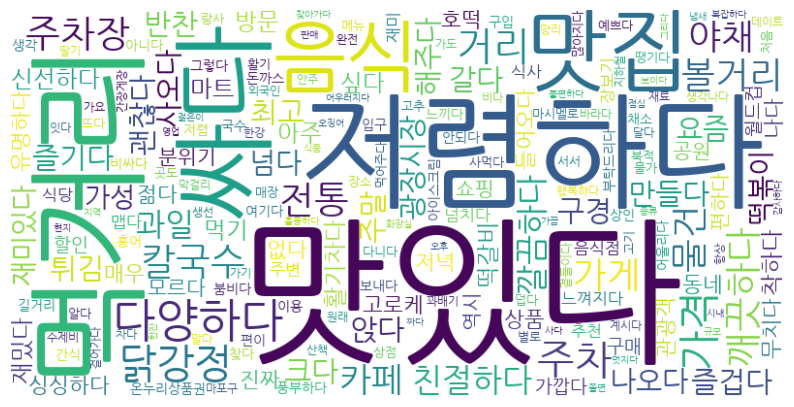

In [30]:
font_path = "C:/Users/mink5/Desktop/석사과정/2학기/다변량통계방법론/기말 프로젝트/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf"
all_keywords_m1 = [keyword for keywords_list in mangwon_1['content_keywords'] for keyword in keywords_list]
word_freq_m1 = Counter(all_keywords_m1) # 빈도수 계산
wordcloud_m1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_m1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_m1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
top_5_words_m1 = [word for word, _ in word_freq_m1.most_common(5)]
print(top_5_words_m1)

['맛있다', '저렴하다', '먹거리', '싸다', '맛집']


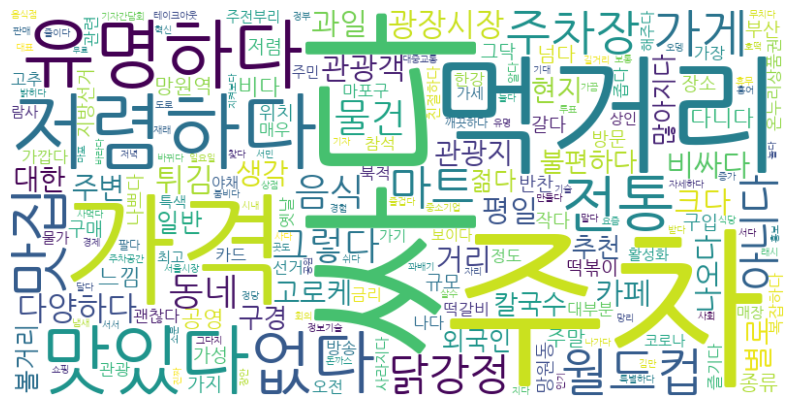

In [32]:
font_path = "C:/Users/mink5/Desktop/석사과정/2학기/다변량통계방법론/기말 프로젝트/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf"
all_keywords_m0 = [keyword for keywords_list in mangwon_0['content_keywords'] for keyword in keywords_list]
word_freq_m0 = Counter(all_keywords_m0) # 빈도수 계산
wordcloud_m0 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_m0)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_m0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
top_5_words_m0 = [word for word, _ in word_freq_m0.most_common(5)]
print(top_5_words_m0)

['싸다', '주차', '먹거리', '가격', '저렴하다']


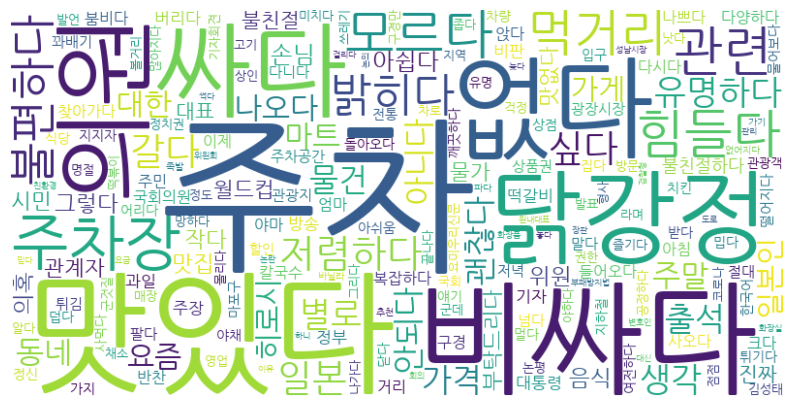

In [34]:
font_path = "C:/Users/mink5/Desktop/석사과정/2학기/다변량통계방법론/기말 프로젝트/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf"
all_keywords_m0 = [keyword for keywords_list in mangwon_1m['content_keywords'] for keyword in keywords_list]
word_freq_m0 = Counter(all_keywords_m0) # 빈도수 계산
wordcloud_m0 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_m0)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_m0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
top_5_words_m0 = [word for word, _ in word_freq_m0.most_common(5)]
print(top_5_words_m0)

['주차', '맛있다', '비싸다', '없다', '싸다']


In [36]:
# json 파일로 저장
sentiment_0_key.to_json('sentiment_0_keywords_verb.json', orient='records')
sentiment_1_key.to_json('sentiment_1_keywords_verb.json', orient='records')
sentiment_1m_key.to_json('sentiment_1m_keywords_verb.json', orient='records')

### 자양시장

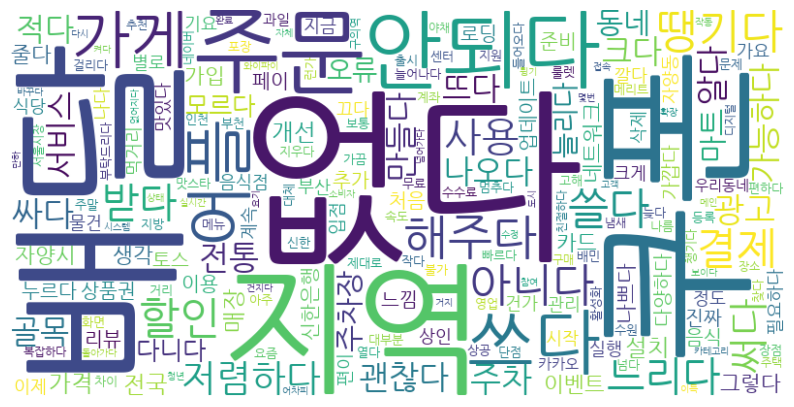

In [37]:
all_keywords_j0 = [keyword for keywords_list in jayang_0['content_keywords'] for keyword in keywords_list]
word_freq_j0 = Counter(all_keywords_j0) # 빈도수 계산
wordcloud_j0 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_j0)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_j0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
top_5_words_j0 = [word for word, _ in word_freq_j0.most_common(5)]
print(top_5_words_j0)

['없다', '배달', '쿠폰', '지역', '주문']


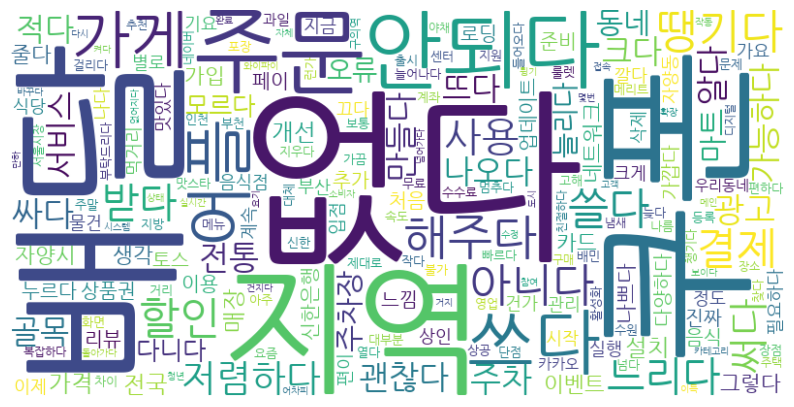

In [39]:
all_keywords_j1 = [keyword for keywords_list in jayang_1['content_keywords'] for keyword in keywords_list]
word_freq_j1 = Counter(all_keywords_j1) # 빈도수 계산
wordcloud_j1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_j1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_j0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [40]:
top_5_words_j1 = [word for word, _ in word_freq_j1.most_common(5)]
print(top_5_words_j1)

['쿠폰', '할인', '저렴하다', '맛있다', '배달']


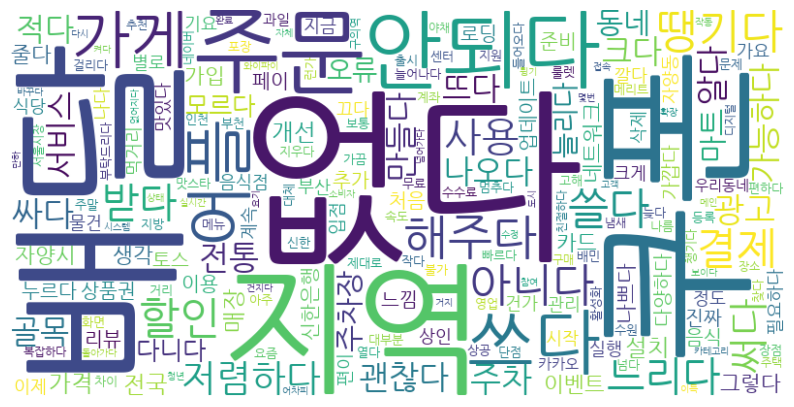

In [41]:
all_keywords_j1 = [keyword for keywords_list in jayang_1m['content_keywords'] for keyword in keywords_list]
word_freq_j1 = Counter(all_keywords_j1) # 빈도수 계산
wordcloud_j1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_j1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_j0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [42]:
top_5_words_j1 = [word for word, _ in word_freq_j1.most_common(5)]
print(top_5_words_j1)

['안되다', '주문', '쿠폰', '없다', '땡기다']


## 2. 명사 키워드만 추출

In [43]:
def preprocess_words_new_noun(text):
    okt = Okt()
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]", "", text)
    text = remove_emojis(text)  # remove_emojis 함수는 이전에 정의된 함수라고 가정합니다.
    text = okt.normalize(text)
    words = okt.pos(text, stem=True)
    nouns = [word[0] for word in words if word[1] == 'Noun']
    additional_stopwords = {'오늘', '내일','다음날','다음','모레','어제', '이번주', '다음주', '이번달', '올해','다음달','작년','내년',
                            '예전','한번','두번','많다','먹다','드리다','주다','자주','종종','지나가다','들리다',
                           '시장', '재래시장', '좋다', '서울', '들어가다', '가보다','가다','가야','오다','그냥','사람',
                           '보다', '맛보다', '보고','살다','정말','가면','오면','찍다','들다','해보다','다녀오다','생기다',
                           '좋아하다','맞다','만나다','망원','자양','망원시장','자양시장','자다','서울시','위해','안녕','안녕하다',
                           '보고오다','대해','알고싶다','빼다','가줄','최근','때문','근처','한국',
                           '요즘', '진짜', '대한', '매우', '라며', '검찰', '정치검찰', '오라','항상','하니','너무',
                           '성남','이재명','총장','독재','민주당','정치'}
    total_stopwords = stopwords.union(additional_stopwords)
    filtered_words = [word for word in nouns if word not in total_stopwords]
    final_text = " ".join(filtered_words)
    return final_text

In [44]:
sentiment_1_key_noun = sentiment_1.copy()
sentiment_1_key_noun['content'] = sentiment_1_key_noun['content'].astype(str)
sentiment_1_key_noun['content_keywords'] = sentiment_1_key_noun['content'].apply(preprocess_words_new_noun).apply(extract_keywords)
sentiment_1_key_noun

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
9,민원,망원시장,20221220,경성중고사거리 따릉이 대여소 설치 요청드립 니다,안녕하세요. 저는 따릉이를 애용하는 마포구민입니다. 상암동에는 따릉이 대여소를 아주...,0,0,0,0,1,579,"[북로, 문의, 구민, 전혀, 따릉이]"
50,광진땡겨요어플리뷰,자양전통시장,20220929,0,"앱 알림과 주문, 배달까지 모두 만족스러웠어요. 특히 첫구매, 재구매 혜택으로 만 ...",0,0,0,0,1,222,"[사항, 주문, 맛스타, 예상, 알림]"
53,광진땡겨요어플리뷰,자양전통시장,20220518,0,런칭한지 얼마 안됐다고 아는데 그런 것 치고는 앱 구동은 안정적이네요. 대신 뭐 보...,0,0,0,0,1,159,"[런칭한, 버벅이, 그거, 화면, 점주]"
65,광진땡겨요어플리뷰,자양전통시장,20221020,0,잘 사용하고 있습니다. 우선 이벤트나 혜택도 많고 할인쿠폰도 여러 쿠폰 중첩 사용가...,0,0,0,0,1,208,"[할인, 쿠폰, 혜택, 배달, 사용]"
68,광진땡겨요어플리뷰,자양전통시장,20240310,0,초기에는 가맹점 수가 적어서 많이 이용 못했지만 지금은 왠만한 음식은 다 시킬 수 ...,0,0,0,0,1,160,"[할인, 상품권, 이용, 사용, 기능]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7796,인스타그램,망원시장,20240316,0,화창한 봄기운 가득한 토요일요기요거 활짝 열었습니다봄이 성큼 다가왔어요오늘은 요기요...,0,"[#망원시장, #망원동맛집, #비건그릭요거트맛집, #그릭요거트맛집, #망리단길맛집,...",0,0,1,283,"[거도, 주시, 상황, 성큼, 요거트]"
7797,인스타그램,망원시장,20231027,0,알록달록한 무지개 같은 닭강정을 파는 곳이다.망원시장에 방문하면 무조건 방문해야하기...,0,"[#망원동맛집, #망원시장, #마포구맛집, #망원역맛집, #닭강정맛집, #망원시장맛집]",0,0,1,472,"[강정은, 먹기, 닭다리, 아예, 맛집]"
7798,인스타그램,망원시장,20230920,0,나처럼 훈훈한 사람들만 방문해야 하는 곳이 있다.서울 마포구 망원역 망원시장 근처에...,0,"[#훈훈호떡, #먹세권_마포구, #먹세권_망원역]",0,0,1,358,"[연락처, 포은로, 지하, 오레오, 링클]"
7799,인스타그램,망원시장,20231211,0,망원시장 같이 갈 친구 태그 !!#재슐랭망원 #망원시장 #망원시장투어근처 들를 일이...,0,"[#재슐랭_망원, #망원시장, #망원시장투어, #우이락, #재슐랭가이드, #재슐랭,...",0,0,1,330,"[워스트, 마요, 재슐랭, 완전, 고로케]"


In [45]:
sentiment_0_key_noun = sentiment_0.copy()
sentiment_0_key_noun['content'] = sentiment_0_key_noun['content'].astype(str)
sentiment_0_key_noun['content_keywords'] = sentiment_0_key_noun['content'].apply(preprocess_words_new_noun).apply(extract_keywords)
sentiment_0_key_noun

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
2,민원,자양전통시장,20200622,청년몰을 조성해주세요!,청년 실업문제와 전통시장 부흥을 위해 화양시장 혹은 자양전통시장에 청년몰을 조성해주...,0,0,0,0,0,422,"[상점가, 상인, 창업, 기반시설, 마케팅]"
5,민원,망원시장,20230814,망원시장의 이상한 영어 간판 - harmony and pleasant,주말에 망원시장에 갔다가 망원시장과 월드컵시장 사이 도로변에 붙어 있는 첨부한 망원...,0,0,0,0,0,640,"[월드컵, 외국인, 외국어, 무료, 와이파이]"
6,민원,망원시장,20230801,이상한 망원로의 망원시장-월드컵시장 아케이드간 횡단보도 2,새올 전자민원창구가 이상하여 이송한 민원은 동일민원으로 선택할 수 없어서 이전 민원...,0,0,0,0,0,740,"[횡단보도, 교차로, 부산, 월드컵, 국제]"
7,민원,망원시장,20230723,이상한 망원로의 망원시장-월드컵시장 아케이드간 횡단보도,망원로의 망원시장 아케이드와 월드컵시장 아케이드간에 횡단보도가 첨부와 같이 이상하게...,0,0,0,0,0,408,"[일본, 교차로, 횡단보도, 숲길, 마포세무서]"
8,민원,망원시장,20230627,망원동 시장거리 발전을 위한 제언,"망원동은 최근 MZ세대들에게 핫플레이스로 급부상하고 있는 지역입니다. 성수, 연남,...",0,0,0,0,0,676,"[세대, 외국인, 발전, 개선, 업체]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7760,네이버카페,자양전통시장,20240125,2228수퍼바이저 지역상권 활성화 행사 수퍼바이저 모집,지역상권 활성화 프로젝트 수퍼바이저 모집 안내 2월 02일08일까지 진행되는 지역시...,0,0,0,[연락은 언제까지 오나요?],0,1015,"[문의사항, 근무, 동해시, 마이, 부전]"
7762,네이버카페,자양전통시장,20240129,광진커튼 자양동커튼 차르르 블라인드 화이트인테리어 방문출장설치,광진커튼 자양동커튼 차르르 블라인드 화이트인테리어 방문출장설치 광진구 커튼 중곡동...,0,0,0,0,0,2268,"[광장동, 광장, 워커힐, 파크빌, 청계천로]"
7768,네이버카페,자양전통시장,20240226,화양동 371번지 일원 건대역 모아타운 홍보관에서 동의서 징구시작한다네요 .. 애견...,자양4동 모아타운이 성공적으로 조합설립을 위한 창립총회가 통과돼고 나니 자양1동 2...,0,0,0,"[오늘 아침부터 애견 한마리 맡긴다고해서 일찍 문열로갑니다, 종이는 사무실로가면주나...",0,940,"[타운, 거리, 주택, 정문, 동네]"
7782,인스타그램,망원시장,20240316,0,.. 조금 멀리 먹어 보았다 아이스가 들어간 마시멜로 주문하면 그 자리에서 구워...,0,"[#망원시장, #만원시장, #한국여행, #한국여행, #마시멜로아이스, #한국음식]",0,0,0,52,"[마시멜로, 주문, 아이스, 멀리, 자리]"


In [46]:
sentiment_1m_key_noun = sentiment_1_.copy()
sentiment_1m_key_noun['content'] = sentiment_1m_key_noun['content'].astype(str)
sentiment_1m_key_noun['content_keywords'] = sentiment_1m_key_noun['content'].apply(preprocess_words_new_noun).apply(extract_keywords)
sentiment_1m_key_noun

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length,content_keywords
0,민원,자양전통시장,20220608,자양전통시장 주차장의 안일한 운영,저는 2022년 5월 24일 13시 7분 자양전통시장 이용을 위해 자양전통시장 주차...,0,0,0,0,-1,1908,"[연락처, 상태, 주차장, 주지, 안내]"
1,민원,자양전통시장,20210312,자양전통시장 주차장,안녕하십니까 담당자님 자양전통시장을 자주 이용하는데 이번에 주차장을 이용하면서 불편...,0,0,0,0,-1,1031,"[결제, 현금, 할인, 금액, 주차장]"
3,민원,자양전통시장,20200520,자양 1동 새벽 도로공사 민원 신청합니다.,안녕하세요. 자양 1동 주민입니다. 최근 자양전통시장으로 진입하는 골목의 도로를 공...,0,0,0,0,-1,446,"[주민, 상응, 퇴근, 세면대, 답변]"
4,민원,망원시장,20231012,망원시장 공영주차장 부당이득은 1년넘게 방치하고 주차요금은 50퍼센트 인상,첨부와 같이 2022년 06월 18일 망원시장 공영주차장의 시장할인 제도의 불합리한...,0,0,0,0,-1,769,"[주차장, 주차, 할인, 요금, 부당이득]"
10,민원,망원시장,20220515,식품 위생법 위반한 업체 고발합니다.,본인은 글을 올리는 금일 마포구 망원시장에 있는 민영활어횟집에서 쵸밥을 샀고 간장과...,0,0,0,0,-1,226,"[민영, 신고, 남자, 쵸밥, 금일]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7759,네이버카페,자양전통시장,20240113,구피사랑컵 릴레이#8,커피 머신이 수동인데다 한두잔 뽑기에는 준비과정이 좀 있어서 핸드 드립으로 내려 ...,0,0,0,[저는 알고있지요오오옹!자양시장!!사진만봐도 어디서 본 느낌인데 하고 올라갔더니 쥬...,-1,411,"[찐빵, 커피, 가게, 튀김, 비닐]"
7764,네이버카페,자양전통시장,20240205,적중!!! 자양골목시장 주변 노후주거지ft. 2040 광진플랜,늦었습니다! 2040 광진플랜 설명회를 지구불시착님과 요정의요정님께서 다녀오신지도 ...,0,0,0,[대박입니다!!!! 완전 퍼펙트한 적중입니다!!!! 이렇게 깔끔하게 정리해주셔서 ...,-1,677,"[타운, 대한민국, 광진구, 중심지, 고민정]"
7765,네이버카페,자양전통시장,20240211,조양마트 첫방문기,"평소 동선상 지나갈 일이 없어 직접방문은 못하고, 인스타 피드나 블로그 글로만 보던...",0,0,0,"[조양이 느낌상 구판장 앞지르지 않았나 싶네요.., 와인/위스키 매출기준 1위 입니...",-1,654,"[마트, 사이트, 사업, 구매, 정보]"
7770,네이버카페,자양전통시장,20240302,자양전통시장에 장보러 왔어요,"2번째 단행본 ""수도권비주택 투자 수업"" 출간되었습니다 구매방법 공지 htt...",0,0,0,"[봄동도 나왔군요 ㅎㅎ 시장에서 맛있는거 많이 사오셨네요 ☺️🤗, 봄하면 봄동이죠....",-1,815,"[실시간, 영상, 화면, 설정, 인터넷]"


In [47]:
# json 파일로 저장
sentiment_0_key_noun.to_json('sentiment_new_0_keywords_noun.json', orient='records')
sentiment_1_key_noun.to_json('sentiment_new_1_keywords_noun.json', orient='records')
sentiment_1m_key_noun.to_json('sentiment_new_1m_keywords_noun.json', orient='records')

In [48]:
mangwon_0n = sentiment_0_key_noun[sentiment_0_key_noun['market']=='망원시장']
jayang_0n = sentiment_0_key_noun[sentiment_0_key_noun['market']=='자양전통시장']

mangwon_1n = sentiment_1_key_noun[sentiment_1_key_noun['market']=='망원시장']
jayang_1n = sentiment_1_key_noun[sentiment_1_key_noun['market']=='자양전통시장']

mangwon_1nm = sentiment_1m_key_noun[sentiment_1m_key_noun['market']=='망원시장']
jayang_1nm = sentiment_1m_key_noun[sentiment_1m_key_noun['market']=='자양전통시장']

### 망원시장

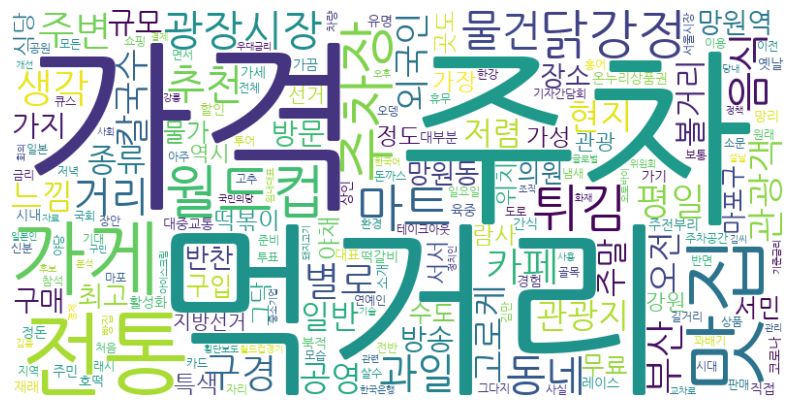

In [49]:
all_keywords_m0 = [keyword for keywords_list in mangwon_0n['content_keywords'] for keyword in keywords_list]
word_freq_m0 = Counter(all_keywords_m0) # 빈도수 계산
wordcloud_m0 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_m0)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_m0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [50]:
top_5_words_m0 = [word for word, _ in word_freq_m0.most_common(5)]
print(top_5_words_m0)

['주차', '먹거리', '가격', '전통', '맛집']


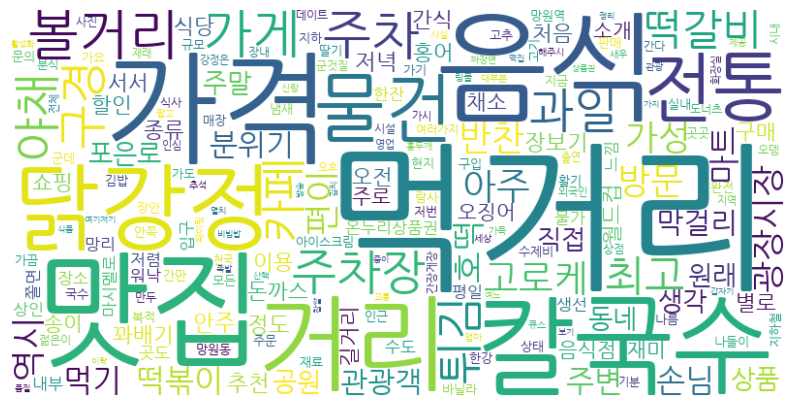

In [51]:
all_keywords_m1 = [keyword for keywords_list in mangwon_1n['content_keywords'] for keyword in keywords_list]
word_freq_m1 = Counter(all_keywords_m1) # 빈도수 계산
wordcloud_m1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_m1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_m1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [52]:
top_5_words_m1 = [word for word, _ in word_freq_m1.most_common(5)]
print(top_5_words_m1)

['먹거리', '맛집', '가격', '음식', '칼국수']


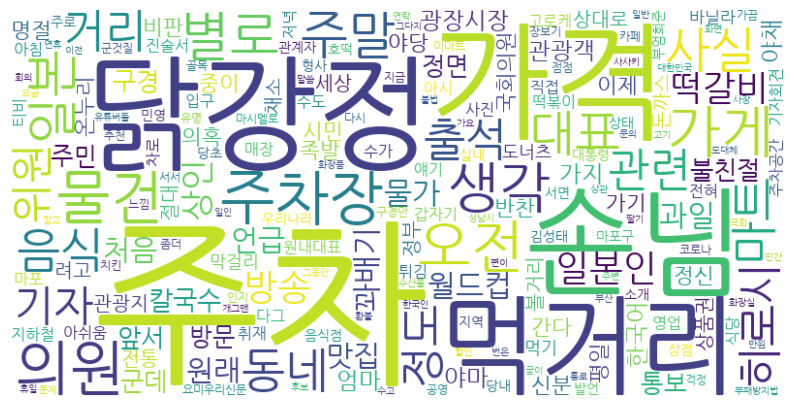

In [53]:
all_keywords_m1 = [keyword for keywords_list in mangwon_1nm['content_keywords'] for keyword in keywords_list]
word_freq_m1 = Counter(all_keywords_m1) # 빈도수 계산
wordcloud_m1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_m1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_m1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [54]:
top_5_words_m1 = [word for word, _ in word_freq_m1.most_common(5)]
print(top_5_words_m1)

['주차', '가격', '닭강정', '손님', '먹거리']


### 자양시장

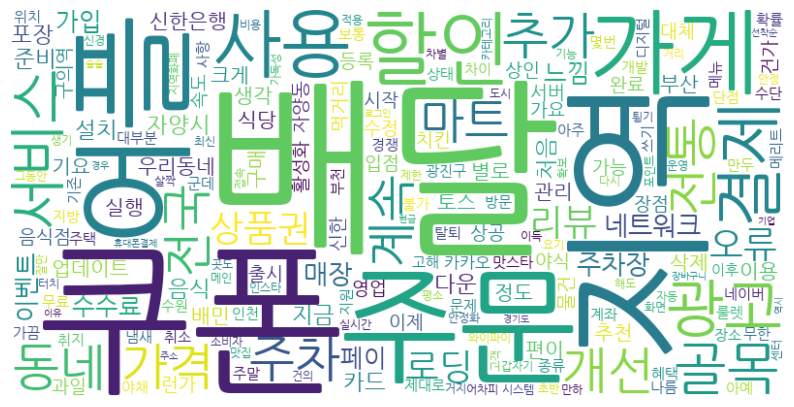

In [55]:
all_keywords_j0 = [keyword for keywords_list in jayang_0n['content_keywords'] for keyword in keywords_list]
word_freq_j0 = Counter(all_keywords_j0) # 빈도수 계산
wordcloud_j0 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_j0)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_j0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [56]:
top_5_words_j0 = [word for word, _ in word_freq_j0.most_common(5)]
print(top_5_words_j0)

['배달', '쿠폰', '지역', '주문', '어플']


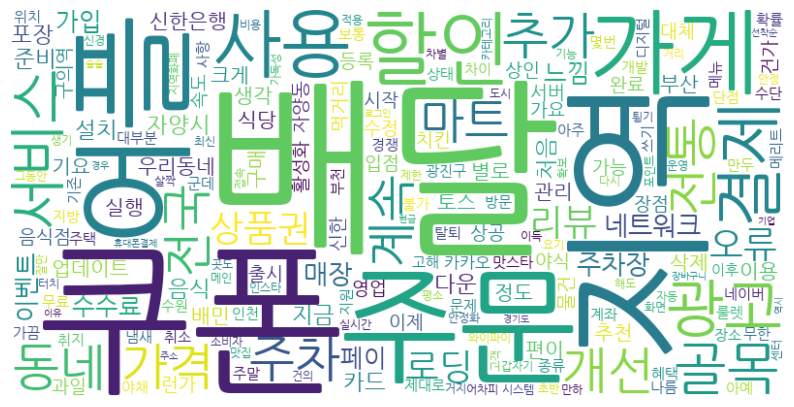

In [57]:
all_keywords_j1 = [keyword for keywords_list in jayang_1n['content_keywords'] for keyword in keywords_list]
word_freq_j1 = Counter(all_keywords_j1) # 빈도수 계산
wordcloud_j1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_j1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_j0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [58]:
top_5_words_j1 = [word for word, _ in word_freq_j1.most_common(5)]
print(top_5_words_j1)

['할인', '쿠폰', '배달', '주문', '구의역']


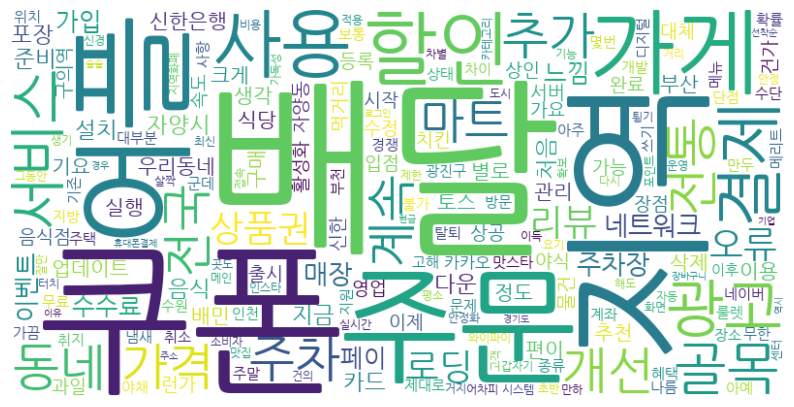

In [59]:
all_keywords_j1 = [keyword for keywords_list in jayang_1nm['content_keywords'] for keyword in keywords_list]
word_freq_j1 = Counter(all_keywords_j1) # 빈도수 계산
wordcloud_j1 = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq_j1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_j0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
top_5_words_j1 = [word for word, _ in word_freq_j1.most_common(5)]
print(top_5_words_j1)

['주문', '쿠폰', '어플', '배달', '가게']


### 부정 데이터에서 '배달' 단어 들어간 내용 확인

In [61]:
sentiment_0[(sentiment_0['content'].str.contains('배달'))&(sentiment_0['market']=='자양전통시장')]

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length
77,광진땡겨요어플리뷰,자양전통시장,20240206,0,"잘 쓰고 있습니다만, 지역사랑상품권 사용 가능한 어플 중 제일 좋은 점이 장점인데 ...",0,0,0,0,0,84
120,광진땡겨요어플리뷰,자양전통시장,20231021,0,같은 비용을 내도 배달이 타앱으로 주문하는것보다 느림. 고객센터는 실시간으로 도움받...,0,0,0,0,0,50
121,광진땡겨요어플리뷰,자양전통시장,20230925,0,이 놀라운 배달 어플은 메뉴를 고르면 배달가능 지역이 아니라는 말만 나온다. 이럴거...,0,0,0,0,0,109
201,광진땡겨요어플리뷰,자양전통시장,20230804,0,서울경기를 제외하고 큰 도시는 꽤 사용할만 어플이라고 보는데 지방의 소도시 흔히 시...,0,0,0,0,0,191
228,광진땡겨요어플리뷰,자양전통시장,20240312,0,배달 가능 지역 아니거나 입점 가게가 없음,0,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...,...,...
2246,광진땡겨요어플리뷰,자양전통시장,20221121,0,새벽 배달은 언제쯤부터 될까요,0,0,0,0,0,16
2355,광진땡겨요어플리뷰,자양전통시장,20220909,0,아니 지방은뭐 배달없음,0,0,0,0,0,13
2448,광진땡겨요어플리뷰,자양전통시장,20230709,0,성동구 성수동에서 배달 되나요,0,0,0,0,0,16
2481,광진땡겨요어플리뷰,자양전통시장,20220831,0,개사기배달료받아요,0,0,0,0,0,9


In [62]:
data_new[data_new['source']=='광진땡겨요어플리뷰']

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length
41,광진땡겨요어플리뷰,자양전통시장,20240213,0,서울만 시행할때 초창기부터 이용했는데 현재는 신한은행 비이용 고객은 특히 혜택 별로...,0,0,0,0,-1,318
42,광진땡겨요어플리뷰,자양전통시장,20220101,0,"오픈한지 얼마 안 된거 치고는 안정적입니다. 실사용자로서 한가지 불편한 점은 한식,...",0,0,0,0,-1,363
43,광진땡겨요어플리뷰,자양전통시장,20220831,0,컨셉이나 콘텐츠는 나쁘지 않은데 어플의 사용감이 별롭니다. 사용하는 흐름이 뚝뚝 끊...,0,0,0,0,-1,271
44,광진땡겨요어플리뷰,자양전통시장,20240213,0,서울만 시행할때 초창기부터 이용했는데 현재는 신한은행 비이용 고객은 특히 혜택 별로...,0,0,0,0,-1,318
45,광진땡겨요어플리뷰,자양전통시장,20220101,0,"오픈한지 얼마 안 된거 치고는 안정적입니다. 실사용자로서 한가지 불편한 점은 한식,...",0,0,0,0,-1,363
...,...,...,...,...,...,...,...,...,...,...,...
2598,광진땡겨요어플리뷰,자양전통시장,20220807,0,노무현,0,0,0,0,-1,3
2599,광진땡겨요어플리뷰,자양전통시장,20220724,0,쓰레기,0,0,0,0,-1,3
2600,광진땡겨요어플리뷰,자양전통시장,20211222,0,땡깁시다,0,0,0,0,1,4
2601,광진땡겨요어플리뷰,자양전통시장,20220807,0,땡깁니다,0,0,0,0,1,4


In [63]:
duplicate_rows = data_new[data_new['source'] == '광진땡겨요어플리뷰'].duplicated(keep=False)
data_new[data_new['source'] == '광진땡겨요어플리뷰'][duplicate_rows]

,source,market,date,title,content,news,hashtags,revisit,reply,sentiment,content_length
41,광진땡겨요어플리뷰,자양전통시장,20240213,0,서울만 시행할때 초창기부터 이용했는데 현재는 신한은행 비이용 고객은 특히 혜택 별로...,0,0,0,0,-1,318
42,광진땡겨요어플리뷰,자양전통시장,20220101,0,"오픈한지 얼마 안 된거 치고는 안정적입니다. 실사용자로서 한가지 불편한 점은 한식,...",0,0,0,0,-1,363
43,광진땡겨요어플리뷰,자양전통시장,20220831,0,컨셉이나 콘텐츠는 나쁘지 않은데 어플의 사용감이 별롭니다. 사용하는 흐름이 뚝뚝 끊...,0,0,0,0,-1,271
44,광진땡겨요어플리뷰,자양전통시장,20240213,0,서울만 시행할때 초창기부터 이용했는데 현재는 신한은행 비이용 고객은 특히 혜택 별로...,0,0,0,0,-1,318
45,광진땡겨요어플리뷰,자양전통시장,20220101,0,"오픈한지 얼마 안 된거 치고는 안정적입니다. 실사용자로서 한가지 불편한 점은 한식,...",0,0,0,0,-1,363
46,광진땡겨요어플리뷰,자양전통시장,20220831,0,컨셉이나 콘텐츠는 나쁘지 않은데 어플의 사용감이 별롭니다. 사용하는 흐름이 뚝뚝 끊...,0,0,0,0,-1,271
2496,광진땡겨요어플리뷰,자양전통시장,20240306,0,좋아요,0,0,0,0,1,3
2586,광진땡겨요어플리뷰,자양전통시장,20240306,0,좋아요,0,0,0,0,1,3
